# 프로젝트 DB 기반 생존(노쇼) 예측 실습
이 노트북은 기존 타이타닉 생존자 예측 로직을 유지하면서, 데이터셋만 프로젝트 DB의 `appointment` 테이블로 교체하여 학습을 수행하는 과정을 담고 있습니다.

In [1]:
# [필수 라이브러리 임포트 및 시스템 설정]
import numpy as np                             # 수치 행렬 연산 도구
import pandas as pd                            # 데이터 분석 및 조작 도구
import matplotlib.pyplot as plt                # 시각화 기본 도구
import seaborn as sns                          # 시각화 확장 라이브러리
import pysql                                   # 프로젝트 전용 DB 관리 모듈

import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 (Windows)
matplotlib.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# [데이터 로드: SQL 기반 원격 테이블 접근]
conn, tunnel = pysql.get_db_connection()       # DB 세션 확보
query = """
    SELECT gender, age, under_12_years_old, over_60_years_old, 
           patient_needs_companion, disability, specialty, no_show 
    FROM appointment
"""
titanic_df = pd.read_sql(query, conn)          # 프로젝트 DB에서 데이터 수집
conn.close()                                   # 연결 반납
tunnel.stop()                                  # 서비스 중단

titanic_df.head()                              # 로드된 데이터 상단부 확인

c:\Users\s\Documents\2ndnohow\.venv\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\s\Documents\2ndnohow\.venv\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


db connection success


,gender,age,under_12_years_old,over_60_years_old,patient_needs_companion,disability,specialty,no_show
0,0,11,0,0,0,,physiotherapy,1
1,0,11,0,0,0,,psychotherapy,0
2,1,11,0,0,0,,speech therapy,0
3,1,11,0,0,0,,physiotherapy,0
4,0,68,0,1,1,motor,physiotherapy,0


In [2]:
# [데이터 정보 요약]
titanic_df.info()                              # 컬럼별 타입 및 데이터 누락 여부 점검

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49586 entries, 0 to 49585
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   gender                   49586 non-null  int64 
 1   age                      49586 non-null  int64 
 2   under_12_years_old       49586 non-null  int64 
 3   over_60_years_old        49586 non-null  int64 
 4   patient_needs_companion  49586 non-null  int64 
 5   disability               49586 non-null  object
 6   specialty                49586 non-null  object
 7   no_show                  49586 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 3.0+ MB


### 데이터 컬럼 상세 설명 (Project DB 기준)
- **gender**: 성별 (male, female)
- **age**: 나이 (수치형)
- **under_12_years_old**: 12세 이하 여부 (0: 아니오, 1: 예)
- **over_60_years_old**: 60세 이상 여부 (0: 아니오, 1: 예)
- **patient_needs_companion**: 보호자 동반 필요성 (0: 불필요, 1: 필요)
- **disability**: 장애 등급 (A~Z 등급 체계)
- **specialty**: 진료 과목 (A~Z 등급 체계)
- **no_show**: 노쇼 여부 (0: 출석, 1: 노쇼) => **타겟 변수**

In [3]:
# [결측치 현황 파악]
titanic_df.isnull().sum()                      # 각 컬럼별 Null 값 개수 합계 산출

gender                     0
age                        0
under_12_years_old         0
over_60_years_old          0
patient_needs_companion    0
disability                 0
specialty                  0
no_show                    0
dtype: int64

In [4]:
# [탐색적 데이터 분석 (EDA): 성별 비중 확인]
print("성별 분포: ")
print(titanic_df['gender'].value_counts())     # 남녀 비율 통계 확인

print("\n장애 등급 분포:")
print(titanic_df['disability'].value_counts().head()) # 주요 장애 등급 통계 확인

성별 분포: 
gender
0    37583
1    12003
Name: count, dtype: int64

장애 등급 분포:
disability
intellectual    30877
motor           13563
                 5146
Name: count, dtype: int64


In [5]:
# [성별에 따른 노쇼 현황 집계]
titanic_df.groupby(['gender', 'no_show'])['no_show'].count() # 성별별 노쇼 빈도 분석

gender  no_show
0       0          33991
        1           3592
1       0          10763
        1           1240
Name: no_show, dtype: int64

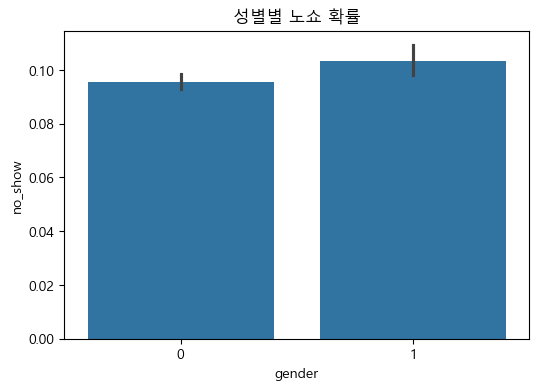

In [6]:
# [시각화: 성별별 노쇼 발생 확률]
plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='no_show', data=titanic_df) # 성별에 따른 노쇼 확률 시각화
plt.title('성별별 노쇼 확률')
plt.show()

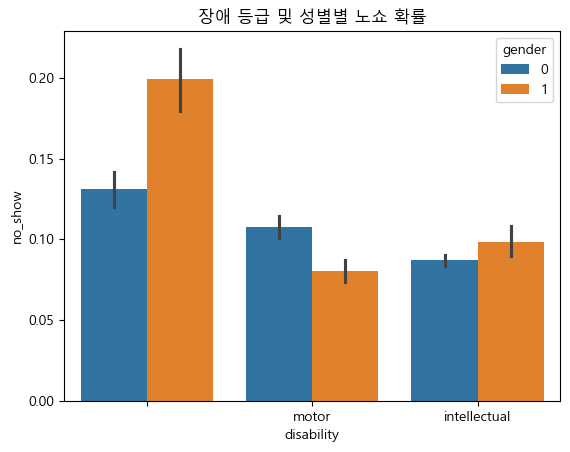

In [7]:
# [시각화: 장애 등급 및 성별 복합 분석]
sns.barplot(x='disability', y='no_show', hue='gender', data=titanic_df) 
plt.title('장애 등급 및 성별별 노쇼 확률')
plt.show()

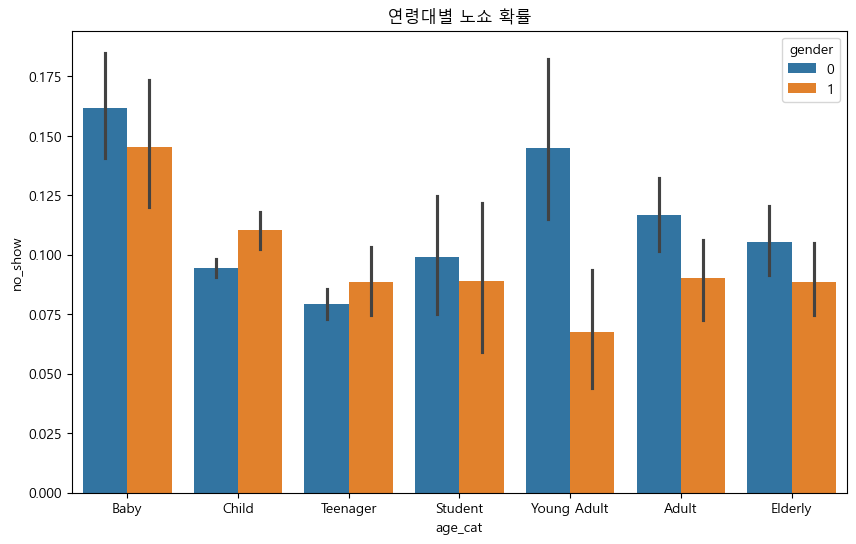

In [8]:
# [연령대별 카테고리화 함수 정의]
def get_category(age):
    cat = ''
    if age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
    return cat

# [연령대별 시각화 분석]
plt.figure(figsize=(10, 6))
group_names = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
titanic_df['age_cat'] = titanic_df['age'].apply(lambda x : get_category(x))

sns.barplot(x='age_cat', y='no_show', hue='gender', data=titanic_df, order=group_names)
plt.title('연령대별 노쇼 확률')
plt.show()
titanic_df.drop('age_cat', axis=1, inplace=True)

In [9]:
# [데이터 전처리: 레이블 인코딩]
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    # 범주형 컬럼 인코딩 대상 설정 (gender, disability, specialty)
    features = ['gender', 'disability', 'specialty']
    for feature in features:
        le = LabelEncoder()
        dataDF[feature] = le.fit_transform(dataDF[feature].astype(str))
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,gender,age,under_12_years_old,over_60_years_old,patient_needs_companion,disability,specialty,no_show
0,0,11,0,0,0,0,4,1
1,0,11,0,0,0,0,5,0
2,1,11,0,0,0,0,7,0
3,1,11,0,0,0,0,4,0
4,0,68,0,1,1,2,4,0


In [10]:
# [모델링을 위한 피처 및 라벨 분리]
y_titanic_df = titanic_df['no_show']                             # 타겟 데이터 분리
X_titanic_df = titanic_df.drop('no_show', axis=1)              # 피처 데이터셋 구성 (7개)

# [학습/테스트 데이터 분할]
from sklearn.model_selection import train_test_split
# 수치 설정 유지: test_size=0.2, random_state=11
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")

Train set size: (39668, 7), Test set size: (9918, 7)


In [11]:
# [다양한 모델을 활용한 분류 학습 및 평가]
from sklearn.tree import DecisionTreeClassifier               # 결정 트리 알고리즘
from sklearn.ensemble import RandomForestClassifier           # 랜덤 포레스트 앙상블
from sklearn.linear_model import LogisticRegression           # 로지스틱 회귀 솔루션
from sklearn.metrics import accuracy_score                    # 정확도 평가 도구

# [모델 객체 생성]
# 수치 설정 유지: random_state=11
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

# 1. DecisionTreeClassifier 학습/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print(f"DecisionTreeClassifier Accuracy: {accuracy_score(y_test, dt_pred):.4f}")

# 2. RandomForestClassifier 학습/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(f"RandomForestClassifier Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

# 3. LogisticRegression 학습/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print(f"LogisticRegression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")

DecisionTreeClassifier Accuracy: 0.9016
RandomForestClassifier Accuracy: 0.9016
LogisticRegression Accuracy: 0.9026


In [12]:
# [K-Fold 교차 검증 수행]
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    kfold = KFold(n_splits=folds)
    scores = []

    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        X_train_fold, X_test_fold = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train_fold, y_test_fold = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        clf.fit(X_train_fold, y_train_fold)
        predictions = clf.predict(X_test_fold)
        accuracy = accuracy_score(y_test_fold, predictions)
        scores.append(accuracy)
        print(f"교차 검증 {iter_count} 정확도: {accuracy:.4f}")
    
    print(f"평균 정확도: {np.mean(scores):.4f}")

print("### DecisionTreeClassifier K-Fold ###")
exec_kfold(dt_clf)

### DecisionTreeClassifier K-Fold ###
교차 검증 0 정확도: 0.9028
교차 검증 1 정확도: 0.8942
교차 검증 2 정확도: 0.9002
교차 검증 3 정확도: 0.9021
교차 검증 4 정확도: 0.9113
평균 정확도: 0.9021


In [13]:
# [GridSearchCV를 이용한 하이퍼 파라미터 튜닝]
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 5, 8]
}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print(f"Best Hyper Parameters: {grid_dclf.best_params_}")
print(f"Best Accuracy Score: {grid_dclf.best_score_:.4f}")

best_dclf = grid_dclf.best_estimator_
dpredictions = best_dclf.predict(X_test)
print(f"Final Accuracy (Target Model): {accuracy_score(y_test, dpredictions):.4f}")

Best Hyper Parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy Score: 0.9025
Final Accuracy (Target Model): 0.9026


In [14]:
# [해결 코드: 정확도 계산 후 업로드]
from sklearn.metrics import accuracy_score

# 1. 먼저 정확도 숫자를 변수에 담습니다! (함수 이름만 쓰면 안 돼요)
my_accuracy = accuracy_score(y_test, dpredictions) 

print(f"현재 계산된 정확도 숫자: {my_accuracy}") # 숫자인지 꼭 확인!

# 2. 이제 auto_push를 호출합니다.
import pysql
import importlib
importlib.reload(pysql)

pysql.auto_push(
    model_obj = best_dclf,
    accuracy  = my_accuracy,  # 위에서 계산한 '숫자'를 넣습니다.
    user_id   = 5,
    description = "정확도 함수 에러 해결 후 업로드"
)

현재 계산된 정확도 숫자: 0.9026013309134906
📡 DB 업로드 중... (User: 5)
db connection success
업로드 완료 (Acc: 0.9026)
✅ [성공] DB 저장 완료!

--- 최신 모델 목록 ---
db connection success
번호    | 작성자ID    | 모델유형            | 정확도      | 저장시간                 | 메모
--------------------------------------------------------------------------------------------------------------
36    | 5        | MachineLearning | 0.9026   | 2026-01-09 03:47:43  | 정확도 함수 에러 해결 후 업로드
35    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:46:22  | DNN Fix Test
34    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:45:27  | DNN 테스트
33    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:41:33  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
32    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:40:17  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
31    | 3        | MachineLearning | 0.9026   | 2026-01-09 03:39:51  | LightGBM 모델 (유헌상)
30    | 4        | MachineLearning | 0.9026   | 2026-01-09 03:38:18  | XGBoost 모델 테스트
29    | 4        | Ma

In [15]:
# [변수 기반 통합 모델 업로드]

# 1. 업로드할 정보 설정 (여기만 수정하세요!)
target_model = best_dclf          # 업로드할 모델 객체 변수명
my_user_id = 5                # 1정유선 2김도영 3유헌상 4정희영 5정용희
final_acc = accuracy_score(y_test, dpredictions)          # 계산된 정확도 변수명 (숫자나 텐서 모두 가능)
memo = "DNN 최종 모델 테스트"     # DB에 남길 메모

# ---------------------------------------------------------
# 2. 업로드 실행
import pysql
from torch import Tensor

# 정확도가 텐서(Tensor) 형태일 경우 숫자로 변환
if isinstance(final_acc, Tensor):
    final_acc = final_acc.item()

print(f"🚀 {target_num if 'target_num' in locals() else ''} 모델 업로드 시작...")

pysql.push_model(
    model_obj=target_model,
    user_id=my_user_id,
    accuracy=float(final_acc), # 숫자로 형변환하여 전달
    description=memo
)

print("✅ 업로드가 완료되었습니다. pysql.list_models()로 번호를 확인하세요!")

🚀  모델 업로드 시작...
db connection success
업로드 완료 (Acc: 0.9026)
✅ 업로드가 완료되었습니다. pysql.list_models()로 번호를 확인하세요!


In [16]:
# [DB에 누적된 모델 히스토리 확인]
pysql.list_models()                            # 전 팀원의 실험 목록 표 형식 출력

db connection success
번호    | 작성자ID    | 모델유형            | 정확도      | 저장시간                 | 메모
--------------------------------------------------------------------------------------------------------------
37    | 5        | MachineLearning | 0.9026   | 2026-01-09 03:47:48  | DNN 최종 모델 테스트
36    | 5        | MachineLearning | 0.9026   | 2026-01-09 03:47:43  | 정확도 함수 에러 해결 후 업로드
35    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:46:22  | DNN Fix Test
34    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:45:27  | DNN 테스트
33    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:41:33  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
32    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:40:17  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
31    | 3        | MachineLearning | 0.9026   | 2026-01-09 03:39:51  | LightGBM 모델 (유헌상)
30    | 4        | MachineLearning | 0.9026   | 2026-01-09 03:38:18  | XGBoost 모델 테스트
29    | 4        | MachineLearning | 0.9022   | 2026-01-09 03:38:16  | R

In [17]:
import pysql
import pandas as pd
import numpy as np

# 1. DB에서 모델 리스트 확인 및 가장 최근 모델 번호 선택
pysql.list_models()
target_num = 22  # [수정] 방금 전 push_model로 생성된 번호를 입력하세요!

# 2. DB에서 모델 불러오기
print(f"\n🔄 DB에서 {target_num}번 모델을 불러오는 중...")
loaded_model = pysql.load_model('model', target_num)

if loaded_model:
    # 3. 테스트할 가상 시나리오 생성 (피처 순서: gender, age, under_12, over_60, companion, disability, specialty)
    # 0: 여성, 1: 남성 | specialty 등은 인코딩된 숫자로 입력 (예: 4)
    scenarios = [
        {'name': '시나리오 A (보호자 동반 어린이)', 'data': [0, 8, 1, 0, 1, 0, 4]},
        {'name': '시나리오 B (청년 1인 방문)', 'data': [1, 26, 0, 0, 0, 0, 5]},
        {'name': '시나리오 C (거동이 불편한 고령자)', 'data': [0, 72, 0, 1, 1, 2, 4]}
    ]

    print(f"\n--- {target_num}번 모델 기반 예측 결과 ---")
    
    for scene in scenarios:
        # 모델 입력용 데이터프레임 생성
        test_df = pd.DataFrame([scene['data']], columns=X_titanic_df.columns)
        
        # 예측 수행
        # 머신러닝 모델(DT, RF)은 predict와 predict_proba 사용 가능
        prediction = loaded_model.predict(test_df)[0]
        
        try:
            # 노쇼(1) 확률 추출
            prob = loaded_model.predict_proba(test_df)[0][1]
            prob_str = f"({prob:.1%} 확률)"
        except:
            prob_str = ""

        result_text = "⚠️ No-Show 위험" if prediction == 1 else "✅ 정상 방문 예상"
        print(f"[{scene['name']}] 결과: {result_text} {prob_str}")
        
    print("\n💡 서비스 가이드: 이 분석을 바탕으로 '고위험군' 시나리오 환자에게는 전날 알림 문자를 강화할 수 있습니다.")

db connection success
번호    | 작성자ID    | 모델유형            | 정확도      | 저장시간                 | 메모
--------------------------------------------------------------------------------------------------------------
37    | 5        | MachineLearning | 0.9026   | 2026-01-09 03:47:48  | DNN 최종 모델 테스트
36    | 5        | MachineLearning | 0.9026   | 2026-01-09 03:47:43  | 정확도 함수 에러 해결 후 업로드
35    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:46:22  | DNN Fix Test
34    | 5        | DeepLearning    | 0.9081   | 2026-01-09 03:45:27  | DNN 테스트
33    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:41:33  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
32    | 5        | DeepLearning    | 0.9026   | 2026-01-09 03:40:17  | PyTorch DNN: ERD 정합성 확보 및 7개 변..
31    | 3        | MachineLearning | 0.9026   | 2026-01-09 03:39:51  | LightGBM 모델 (유헌상)
30    | 4        | MachineLearning | 0.9026   | 2026-01-09 03:38:18  | XGBoost 모델 테스트
29    | 4        | MachineLearning | 0.9022   | 2026-01-09 03:38:16  | R